# neural density estimation --- autoregressive models
In this notebook, we will implement a the masked autoencoder for density estimation (MADE). Recall from the lecture that MADE is a simple autoencoder combined with masks that enforce the autoregressive properties. Lets start with creating the masks. We'll use the approach from Germain et al.(2015). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np 

import matplotlib.pyplot as plt
import corner

In [2]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


# synthetic data
Lets make some complicated target distribution $p(x)$. 

In [3]:
def make_synthetic_data(N, D, device="cpu"):
    """
    More challenging synthetic data for D >= 4:

    - (x0, x1): 3-component Gaussian mixture with different means & covariances
                (including rotated, anisotropic components)
    - x2: nonlinear function of (x0, x1) + noise
          x2 = sin(x0) + 0.5 * x1^2 + eps
    - x3: heavy-tailed (Student-t-like) variable
    - If D > 4, remaining dims are weakly correlated noisy copies.
    """

    assert D >= 4, "This generator assumes at least 4 dimensions."

    # ----- 3-component mixture in (x0, x1) -----
    # Means
    mus = torch.stack([
        torch.tensor([0.0, 0.0], device=device),
        torch.tensor([3.0, -3.0], device=device),
        torch.tensor([-3.0, 3.0], device=device),
    ])  # [3, 2]

    # Covariance matrices (anisotropic + rotated)
    covs = []
    # Component 0: roughly isotropic
    covs.append(torch.tensor([[1.0, 0.2],
                              [0.2, 1.0]], device=device))
    # Component 1: elongated and rotated
    covs.append(torch.tensor([[2.0, 1.5],
                              [1.5, 2.0]], device=device))
    # Component 2: narrow and rotated differently
    covs.append(torch.tensor([[0.5, -0.3],
                              [-0.3, 0.5]], device=device))
    covs = torch.stack(covs, dim=0)  # [3, 2, 2]

    # Mixing probabilities (non-uniform)
    pis = torch.tensor([0.4, 0.35, 0.25], device=device)

    # Sample component indices
    # Multinomial over {0,1,2}
    comp_idx = torch.multinomial(pis, num_samples=N, replacement=True)  # [N]

    # For each sample, get its mean and covariance
    mu = mus[comp_idx]           # [N, 2]
    cov = covs[comp_idx]         # [N, 2, 2]

    # Sample from N(0, I) and transform via Cholesky of cov
    eps = torch.randn(N, 2, device=device)  # [N, 2]
    # Cholesky factor per component
    L = torch.linalg.cholesky(cov)          # [N, 2, 2]
    xy = (L @ eps.unsqueeze(-1)).squeeze(-1) + mu  # [N, 2]

    x0 = xy[:, 0]
    x1 = xy[:, 1]

    # ----- Nonlinear, noisy x2 -----
    # x2 = sin(x0) + 0.5 * x1^2 + noise
    noise_x2 = 0.5 * torch.randn(N, device=device)
    x2 = torch.sin(x0) + 0.5 * x1**2 + noise_x2

    # ----- Heavy-tailed x3 (Student-t like) -----
    # t-dist ~ z / sqrt(u/ν), with z ~ N(0,1), u ~ χ²(ν)
    nu = 3.0
    z = torch.randn(N, device=device)
    u = torch.distributions.Chi2(df=torch.tensor(nu, device=device)).sample((N,))
    x3 = z * torch.sqrt(nu / u)  # Student-t(ν)

    # Stack first 4 dims
    x = torch.stack([x0, x1, x2, x3], dim=-1)  # [N, 4]

    # ----- If D > 4: add weakly correlated extra dims -----
    if D > 4:
        extra_dims = []
        for d in range(D - 4):
            # Each additional dim is a noisy linear combo of (x0, x1, x2, x3)
            w = torch.randn(4, device=device)
            extra = (x @ w) / torch.sqrt(torch.sum(w**2))  # normalized
            extra += 0.3 * torch.randn(N, device=device)   # extra noise
            extra_dims.append(extra.unsqueeze(-1))
        extra_dims = torch.cat(extra_dims, dim=-1)  # [N, D-4]
        x = torch.cat([x, extra_dims], dim=-1)      # [N, D]

    return x

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_63669/598188881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))


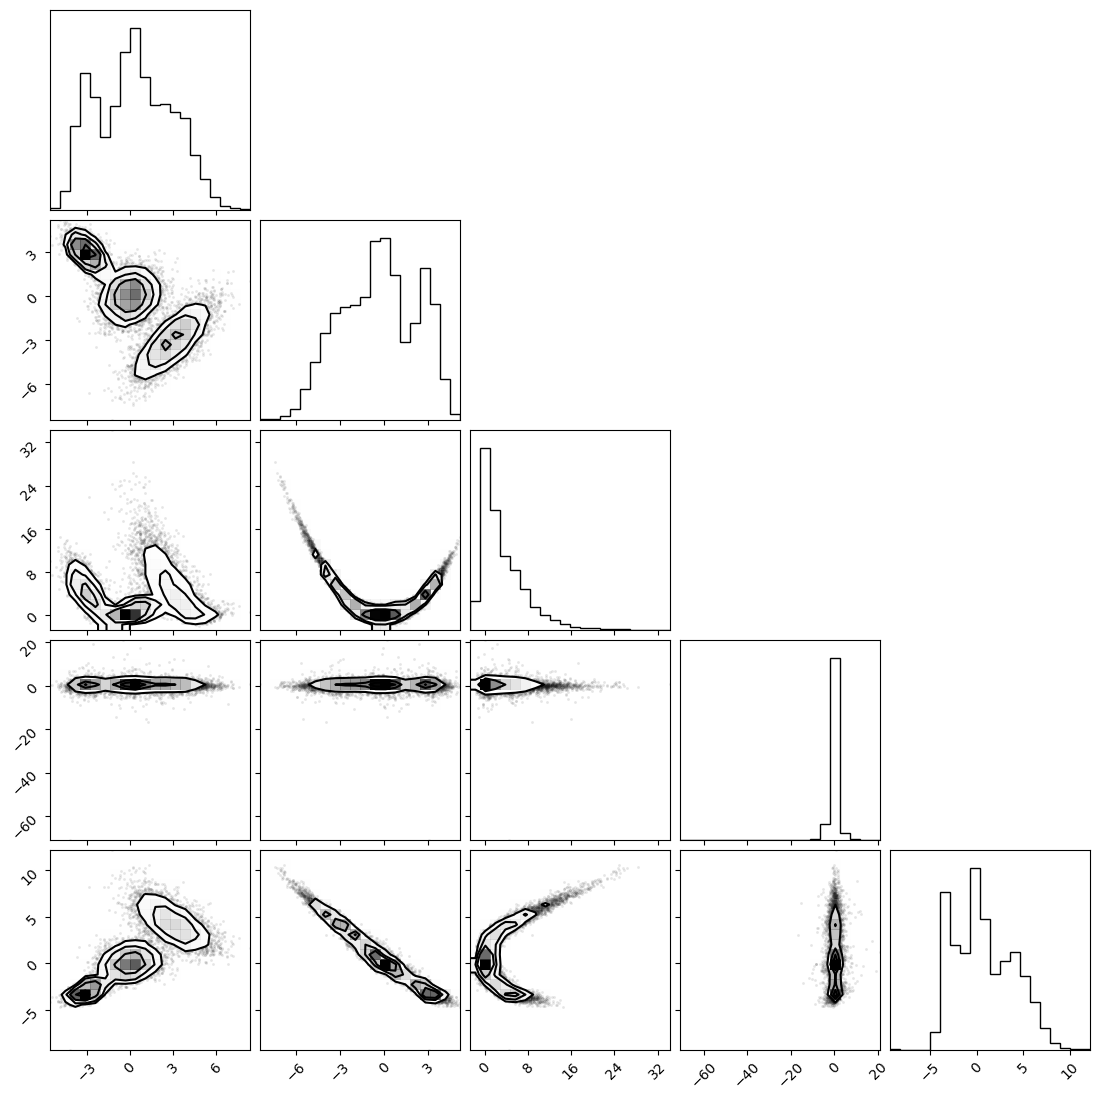

In [4]:
samples = make_synthetic_data(10000, 5, device='cpu')
fig = corner.corner(np.array(samples))

Looks difficult enough that a Gaussian mixture model or other non neural density estimation methods would struggle.

# implementating MADE
Lets start by creating the masks that enforce the autoregressive properties on the encoder

In [5]:
def create_masks(D, hidden_dims, device="cpu"):
    """ Create autoregressive masks for MADE
    """
    # Degrees for input layer: 1, 2, ..., D
    input_degrees = torch.arange(1, D + 1, device=device)

    # Degrees for hidden layers in [1, D-1]
    degrees = []
    for h in hidden_dims:
        # For each hidden unit, sample an integer degree in [1, D-1]
        deg = torch.randint(1, D, size=(h,), device=device)
        degrees.append(deg)

    # Output layer degrees
    output_degrees = torch.arange(1, D + 1, device=device).repeat_interleave(2)

    layer_sizes = [D] + hidden_dims + [D * 2]
    all_degrees = [input_degrees] + degrees + [output_degrees]

    masks = []
    for l in range(len(layer_sizes) - 1):
        d_in = all_degrees[l]      # [n_in]
        d_out = all_degrees[l + 1] # [n_out]
        # We want mask of shape [n_out, n_in] to match Linear's [out, in]
        if l < len(layer_sizes) - 2:
            # Hidden layers: allow if d_out >= d_in
            mask = (d_out[:, None] >= d_in[None, :]).float()
        else:
            # Output layer: allow if d_out > d_in
            mask = (d_out[:, None] > d_in[None, :]).float()

        masks.append(mask)

    return masks

Now we can combine that into a nice MADE model

In [6]:
class MADE(nn.Module):
    def __init__(self, D, hidden_dims, device="cpu"):
        super().__init__()
        self.D = D
        self.hidden_dims = hidden_dims
        self.device = device
        
        layer_sizes = [D] + hidden_dims + [D * 2]

        layers = []
        for in_f, out_f in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_f, out_f))
        self.layers = nn.ModuleList(layers)

        # Build masks
        masks = create_masks(D, hidden_dims, device=self.device)
        # Register masks as buffers so they move with .to(device), but are not trainable
        self.masks = nn.ParameterList(
            [nn.Parameter(m, requires_grad=False) for m in masks]
        )

        # initialize W and b
        for layer in self.layers:
            nn.init.normal_(layer.weight, mean=0.0, std=1.0 / np.sqrt(layer.in_features))
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        '''forward pass 
        '''
        h = x
        L = len(self.layers)
        for l, layer in enumerate(self.layers):
            # Apply autoregressive mask to weights
            masked_weight = layer.weight * self.masks[l]
            h = F.linear(h, masked_weight, layer.bias)
            if l < L - 1:
                h = F.relu(h)

        # Final output: [batch, 2*D]
        B = h.shape[0]
        h = h.view(B, self.D, 2)
        mean = h[..., 0]
        log_std = h[..., 1]
        return mean, log_std

    def log_prob(self, x):
        ''' log p(x)
        '''
        mean, log_std = self.forward(x)
        inv_std = torch.exp(-log_std)
        z = (x - mean) * inv_std
        log_det = -log_std
        logp_per_dim = -0.5 * (np.log(2.0 * np.pi) + z**2) + log_det
        return torch.sum(logp_per_dim, dim=-1)
    
    def sample(self, num_samples):
        ''' sample from MADE
        '''
        self.eval()
        
        x = torch.zeros(num_samples, self.D, device=self.device)
        for i in range(D):
            mean, log_std = self.forward(x)
            std = torch.exp(log_std)
            eps = torch.randn(num_samples, device=self.device)
            x[:, i] = mean[:, i] + std[:, i] * eps
        return x

Now lets train a MADE to estimate this gnarly distribution

In [7]:
D = samples.shape[1] # dimensions
hidden_dims = [128, 64] # architecture of the encoder
lr = 1e-3 # learning rate 
batch_size = 128 # batch size
num_epochs = 100 # number of training epochs

In [8]:
# MADE model
model = MADE(D, hidden_dims, device=device).to(device)

In [9]:
# initialize the ADAM optimzer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
x_train = samples.to(device) 
N_train = samples.shape[0]

num_batches = N_train // batch_size
train_losses = []
for epoch in range(1, num_epochs + 1):
    # shuffle train data at each epoch
    perm = torch.randperm(N_train, device=device)
    x_train = x_train[perm]

    model.train()
    epoch_loss = 0.0

    for i in range(num_batches):
        batch_x = x_train[i * batch_size:(i + 1) * batch_size]
        optimizer.zero_grad()
        lp = model.log_prob(batch_x)     
        loss = -lp.mean()                  
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= num_batches
    train_losses.append(epoch_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: train log p = {epoch_loss:.4f}")

Epoch 001: train log p = 62.9832
Epoch 005: train log p = 9.7030
Epoch 010: train log p = 8.3521
Epoch 015: train log p = 7.5781
Epoch 020: train log p = 7.2865
Epoch 025: train log p = 7.1403
Epoch 030: train log p = 7.1038
Epoch 035: train log p = 7.0621
Epoch 040: train log p = 7.0477
Epoch 045: train log p = 7.0148
Epoch 050: train log p = 7.0028
Epoch 055: train log p = 6.9847
Epoch 060: train log p = 6.9855
Epoch 065: train log p = 6.9749
Epoch 070: train log p = 6.9785
Epoch 075: train log p = 6.9702
Epoch 080: train log p = 6.9597
Epoch 085: train log p = 6.9536
Epoch 090: train log p = 6.9521
Epoch 095: train log p = 6.9654
Epoch 100: train log p = 6.9535


We won't go through a validation step to check for overfitting and etc here but you should always validate the training!

Lets check how well $q_\phi(\theta, \mathcal{D})$ approximates $p(\theta, \mathcal{D})$. 

In [11]:
# draw samples from q_phi
model.eval()
with torch.no_grad():
    q_samples = model.sample(10000).cpu()

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_63669/2257445245.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))
/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_63669/2257445245.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples), color='C1', fig=fig)


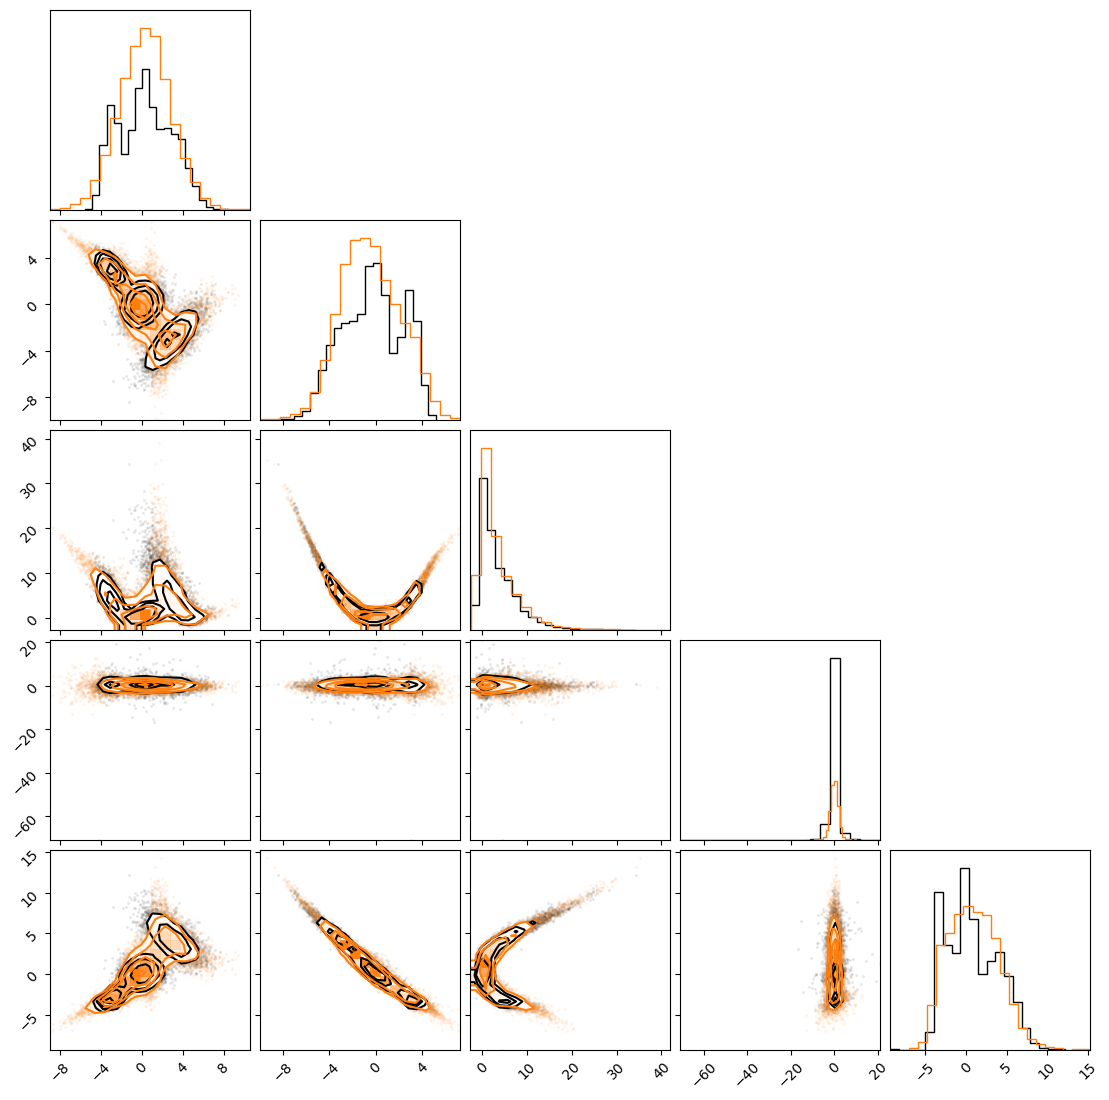

In [12]:
fig = corner.corner(np.array(samples))
fig = corner.corner(np.array(q_samples), color='C1', fig=fig)

Not too bad! 